In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

WORK_PATH = "./"
SOURCE_PATH = os.path.join(WORK_PATH, "src")
EXPORT_PATH = os.path.join("..", "export")
DATA_PATH = os.path.join("..", "data")

sys.path.append(SOURCE_PATH)

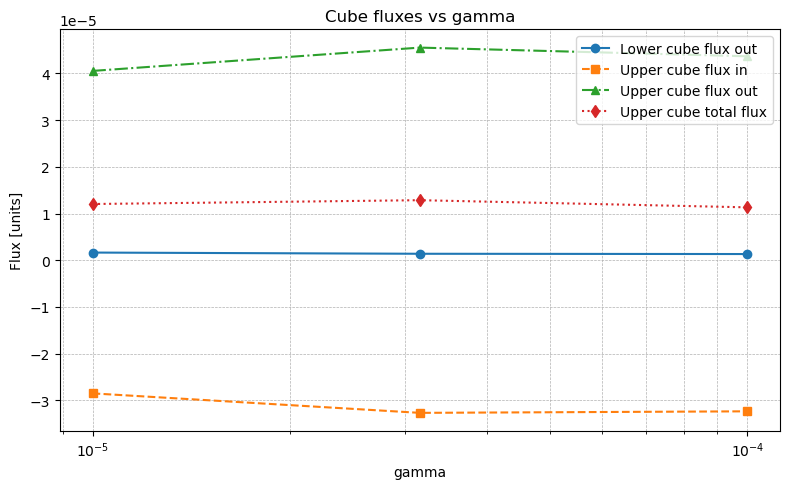

In [9]:
import numpy as np
import single_sweep
df = single_sweep.run_sweep("gamma", np.logspace(-5, -4, 3), 5.0e-6)

import matplotlib.pyplot as plt

x = df["gamma"]
lower_out = df["lower_cube_flux_out"]
upper_in  = df["upper_cube_flux_in"]
upper_out = df["upper_cube_flux_out"]
upper_tot = df["upper_cube_flux"]

plt.figure(figsize=(8,5))

# plot lower cube flux out
plt.plot(x, lower_out, marker='o', linestyle='-', label='Lower cube flux out')

# plot all three upper cube fluxes
plt.plot(x, upper_in,  marker='s', linestyle='--', label='Upper cube flux in')
plt.plot(x, upper_out, marker='^', linestyle='-.', label='Upper cube flux out')
plt.plot(x, upper_tot, marker='d', linestyle=':',  label='Upper cube total flux')

# if your sweep is logarithmic, you might want a log‐x axis:
plt.xscale('log')

plt.xlabel("gamma")
plt.ylabel('Flux [units]')
plt.title('Cube fluxes vs gamma')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()